In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "MS Gothic"
import random
from pprint import pprint
from tqdm import tqdm

In [2]:
!dir

 ドライブ C のボリューム ラベルは Windows です
 ボリューム シリアル番号は DCF0-4C24 です

 C:\Users\kzrn3\Documents\python\signate\JR\code のディレクトリ

2020/12/15  23:02    <DIR>          .
2020/12/15  23:02    <DIR>          ..
2020/12/13  18:22    <DIR>          .ipynb_checkpoints
2020/12/15  23:02             2,064 BaseLine.ipynb
2020/12/13  18:22             1,290 detection.ipynb
2020/12/13  18:20           285,624 FE.ipynb
2020/12/13  18:24               208 次にやること.txt
               4 個のファイル             289,186 バイト
               3 個のディレクトリ  429,775,892,480 バイトの空き領域


In [3]:
train_path = "../train.csv"
test_path = "../test.csv"
info_path = "../info.csv"
sample_path = "../sample_submit.csv"
network_path = "../network.csv"

# FE data

In [4]:
train_df = pd.read_csv(train_path)
train_df

,id,date,lineName,directionCode,trainNo,stopStation,planArrival,delayTime
0,0,20191204,A,1,AFGKvJ,Rlfq,06:11,0.0
1,1,20191204,A,1,AFGKvJ,coZB,06:13,0.0
2,2,20191204,A,1,AFGKvJ,LMww,06:16,0.0
3,3,20191204,A,1,AFGKvJ,VNyR,06:18,0.0
4,4,20191204,A,1,AFGKvJ,jhlV,06:20,0.0
...,...,...,...,...,...,...,...,...
1488880,1488880,20201022,D,2,zbKwea,BCRD,18:47,0.0
1488881,1488881,20201022,D,2,zbKwea,AVjc,18:51,1.0
1488882,1488882,20201022,D,2,zbKwea,uYlv,18:53,0.0
1488883,1488883,20201022,D,2,zbKwea,wwYD,18:59,0.0


In [5]:
len(train_df[train_df["delayTime"]>0.0])

318341

(array([1.450767e+06, 3.097400e+04, 3.694000e+03, 1.526000e+03,
        4.990000e+02, 5.930000e+02, 5.670000e+02, 2.340000e+02,
        2.900000e+01, 2.000000e+00]),
 array([  0.,  12.,  24.,  36.,  48.,  60.,  72.,  84.,  96., 108., 120.]),
 <a list of 10 Patch objects>)

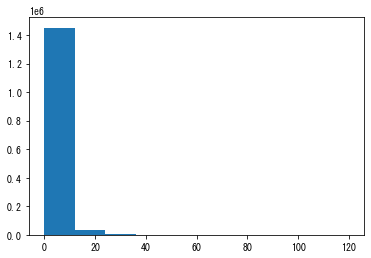

In [6]:
delay_data = train_df["delayTime"]
plt.hist(delay_data)

In [13]:
pd.DataFrame(train_df["delayTime"].value_counts())

,delayTime
0.0,1170544
1.0,79024
2.0,50186
3.0,36197
4.0,28288
...,...
96.0,4
98.0,2
104.0,2
111.0,1


(array([1249568.,   86383.,   50372.,   31297.,   19780.,   13367.,
           9881.,    7539.,    5663.,    3640.]),
 array([ 0. ,  1.9,  3.8,  5.7,  7.6,  9.5, 11.4, 13.3, 15.2, 17.1, 19. ]),
 <a list of 10 Patch objects>)

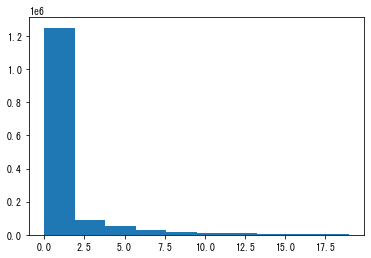

In [7]:
delay_data = train_df[train_df["delayTime"]<20]["delayTime"]
plt.hist(delay_data)

In [8]:
delay_type = train_df["delayTime"].unique()
delay_type.sort()
delay_type

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
       101., 104., 111., 120.])

0.0


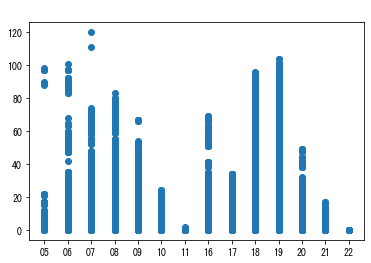

1.0


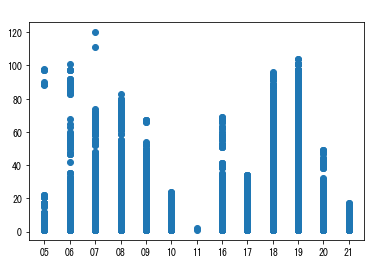

In [9]:
plot_df = train_df[["planArrival","delayTime"]]
plot_df = plot_df.sort_values("planArrival")
time = plot_df["planArrival"].apply(lambda x:x.split(":")[0]).values
delay = plot_df["delayTime"].values
print(min(delay))
plt.scatter(x=time,y=delay)
plt.title("delay全部に対する時間との関係：図1",color="white")
plt.show()

d_df = plot_df[plot_df["delayTime"]>0.0]
time = d_df["planArrival"].apply(lambda x:x.split(":")[0]).values
delay = d_df["delayTime"].values
print(min(delay))
plt.title("delay1.0以上に対する時間との関係：図2",color="white")
plt.scatter(x=time,y=delay)

In [10]:
plot_df["PlanTimeHour"] = plot_df["planArrival"].apply(lambda x:x.split(":")[0]).values
plot_df["delayOr"] = plot_df["delayTime"].apply(lambda x:1 if x>0.0 else 0)
TimeGroupDf = plot_df.groupby("PlanTimeHour")["delayOr"].value_counts()

times = plot_df["PlanTimeHour"].unique()
TimePerDelay = {}
AllTimePerDelay = {}
for t in times:
    if t == "22":
        continue
    NoDelayTimes = TimeGroupDf["{}".format(t)][0]
    DelayTimes = TimeGroupDf["{}".format(t)][1]
    TimePerDelay["{}".format(t)] = DelayTimes / NoDelayTimes
    AllTimePerDelay["{}".format(t)] = DelayTimes / (NoDelayTimes+DelayTimes)

TimePerDelay["22"] = 0
AllTimePerDelay["22"] = 0
print("時間の中で遅延が起きている数と起きていない数の可視化")
pprint(TimeGroupDf)

print()
print("時間における遅延率")
pprint(AllTimePerDelay)

時間の中で遅延が起きている数と起きていない数の可視化
PlanTimeHour  delayOr
05            1              91
              0               4
06            0          117211
              1            4012
07            0          191455
              1           19560
08            0          160932
              1           77160
09            0          132309
              1           61734
10            0            1337
              1             352
11            0              70
              1               2
16            1            2480
              0             346
17            0          152950
              1           32309
18            0          145238
              1           49924
19            0          134184
              1           45020
20            0          133115
              1           25388
21            0            1278
              1             309
22            0             115
Name: delayOr, dtype: int64

時間における遅延率
{'05': 0.9578947368421052,
 '06': 0.033096029631

In [11]:
train_df["PlanTimeHour"] = train_df["planArrival"].apply(lambda x:x.split(":")[0]).values
plot_df["PerDelay"] = plot_df["PlanTimeHour"].map(AllTimePerDelay)
train_df["PerDelay"] = train_df["PlanTimeHour"].map(AllTimePerDelay)

In [12]:
train_df

,id,date,lineName,directionCode,trainNo,stopStation,planArrival,delayTime,PlanTimeHour,PerDelay
0,0,20191204,A,1,AFGKvJ,Rlfq,06:11,0.0,06,0.033096
1,1,20191204,A,1,AFGKvJ,coZB,06:13,0.0,06,0.033096
2,2,20191204,A,1,AFGKvJ,LMww,06:16,0.0,06,0.033096
3,3,20191204,A,1,AFGKvJ,VNyR,06:18,0.0,06,0.033096
4,4,20191204,A,1,AFGKvJ,jhlV,06:20,0.0,06,0.033096
...,...,...,...,...,...,...,...,...,...,...
1488880,1488880,20201022,D,2,zbKwea,BCRD,18:47,0.0,18,0.255808
1488881,1488881,20201022,D,2,zbKwea,AVjc,18:51,1.0,18,0.255808
1488882,1488882,20201022,D,2,zbKwea,uYlv,18:53,0.0,18,0.255808
1488883,1488883,20201022,D,2,zbKwea,wwYD,18:59,0.0,18,0.255808


In [13]:
###遅延<1-12>の確率
times = plot_df["PlanTimeHour"].unique()
TimeType = plot_df["delayTime"].sort_values().unique()
DelayTypeGroup = plot_df.groupby("PlanTimeHour")["delayTime"].value_counts()
TimeDict = {}
for Hour in times:
    AllTimes = DelayTypeGroup["{}".format(Hour)].sum()
    t_dict = {}
    for t in TimeType:
        try:
            DelayTimes = DelayTypeGroup["{}".format(Hour)][t]
        except:
            DelayTimes = 0
        t_dict["{}".format(t)] = DelayTimes / AllTimes
    TimeDict["{}".format(Hour)] = t_dict
pprint(TimeDict)

{'05': {'0.0': 0.042105263157894736,
        '1.0': 0.07368421052631578,
        '10.0': 0.021052631578947368,
        '101.0': 0.0,
        '104.0': 0.0,
        '11.0': 0.08421052631578947,
        '111.0': 0.0,
        '12.0': 0.010526315789473684,
        '120.0': 0.0,
        '13.0': 0.0,
        '14.0': 0.0,
        '15.0': 0.010526315789473684,
        '16.0': 0.042105263157894736,
        '17.0': 0.07368421052631578,
        '18.0': 0.0,
        '19.0': 0.0,
        '2.0': 0.07368421052631578,
        '20.0': 0.0,
        '21.0': 0.06315789473684211,
        '22.0': 0.031578947368421054,
        '23.0': 0.0,
        '24.0': 0.0,
        '25.0': 0.0,
        '26.0': 0.0,
        '27.0': 0.0,
        '28.0': 0.0,
        '29.0': 0.0,
        '3.0': 0.031578947368421054,
        '30.0': 0.0,
        '31.0': 0.0,
        '32.0': 0.0,
        '33.0': 0.0,
        '34.0': 0.0,
        '35.0': 0.0,
        '36.0': 0.0,
        '37.0': 0.0,
        '38.0': 0.0,
        '39.0': 0.0,
   

In [14]:
        

"""
for t in TimeType:
    plot_df["ProbOf{}".format(t)] = np.nan
for Hour in times:
    HourDict = TimeDict["{}".format(Hour)]
    for t in TimeType:
        prob = HourDict["{}".format(t)]
        plot_df.loc[(plot_df["PlanTimeHour"]==Hour)&(plot_df["delayTime"]==t),"ProbOf{}".format(t)] = prob
for t in TimeType:
    plot_df["ProbOf{}".format(t)].fillna(0.0)
"""

ResultProb = {}
for Hour in times:
    ProbH = AllTimePerDelay["{}".format(Hour)]
    DictH = TimeDict["{}".format(Hour)]
    DictP = {}
    for t in TimeType:
        ProbD = DictH["{}".format(t)]
        prob = (ProbH) * (ProbD)
        DictP["{}".format(t)] = prob
    ResultProb["{}".format(Hour)] = DictP


In [15]:
ResultProb["22"]["0.0"] = 1.0
ResultProb

{'05': {'0.0': 0.040332409972299164,
  '1.0': 0.07058171745152354,
  '2.0': 0.07058171745152354,
  '3.0': 0.03024930747922438,
  '4.0': 0.05041551246537396,
  '5.0': 0.020166204986149582,
  '6.0': 0.05041551246537396,
  '7.0': 0.05041551246537396,
  '8.0': 0.07058171745152354,
  '9.0': 0.040332409972299164,
  '10.0': 0.020166204986149582,
  '11.0': 0.08066481994459833,
  '12.0': 0.010083102493074791,
  '13.0': 0.0,
  '14.0': 0.0,
  '15.0': 0.010083102493074791,
  '16.0': 0.040332409972299164,
  '17.0': 0.07058171745152354,
  '18.0': 0.0,
  '19.0': 0.0,
  '20.0': 0.0,
  '21.0': 0.06049861495844876,
  '22.0': 0.03024930747922438,
  '23.0': 0.0,
  '24.0': 0.0,
  '25.0': 0.0,
  '26.0': 0.0,
  '27.0': 0.0,
  '28.0': 0.0,
  '29.0': 0.0,
  '30.0': 0.0,
  '31.0': 0.0,
  '32.0': 0.0,
  '33.0': 0.0,
  '34.0': 0.0,
  '35.0': 0.0,
  '36.0': 0.0,
  '37.0': 0.0,
  '38.0': 0.0,
  '39.0': 0.0,
  '40.0': 0.0,
  '41.0': 0.0,
  '42.0': 0.0,
  '43.0': 0.0,
  '44.0': 0.0,
  '45.0': 0.0,
  '46.0': 0.0,
  '4

# delayがなさそうな条件

In [16]:
#図1と図2より、22時に走っている電車は遅延しにくい

#遅延を学習データでは起こしていない電車のIDが存在していることから遅延しにくい電車がある
#print(len(delay_train_df["trainNo"].value_counts()) / len(train_df["trainNo"].value_counts()))

#delay_train_id = delay_train_df["trainNo"].unique()
#train_id = train_df["trainNo"].unique()

#deplication_list = set(delay_train_id) ^ set(train_id)

#test_df["delayTime_for_train_id"] = test_df["trainNo"].apply(lambda x:0 if x in deplication_list else 1)
#no_delay_id = test_df[(test_df["delayTime_for_train_id"]!=1) & (test_df["target"]==1)]["id"].unique()
"""lambda x:0 if x in no_delay_id"""

'lambda x:0 if x in no_delay_id'

In [17]:
import pandas as pd
eng_test = pd.read_csv("../enginier_data/test.csv")
eng_sample = pd.read_csv("../enginier_data/sample.csv")

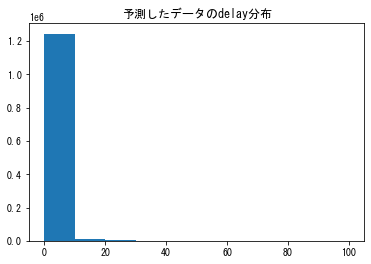

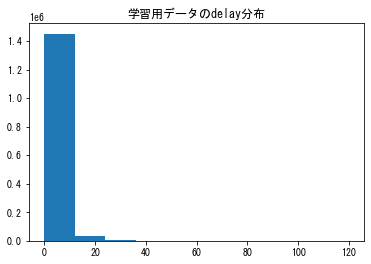

In [18]:
plt.hist(eng_test["delayTime"])
plt.title("予測したデータのdelay分布")
plt.show()
plt.hist(train_df["delayTime"])
plt.title("学習用データのdelay分布")
plt.show()

In [19]:
train_df

,id,date,lineName,directionCode,trainNo,stopStation,planArrival,delayTime,PlanTimeHour,PerDelay
0,0,20191204,A,1,AFGKvJ,Rlfq,06:11,0.0,06,0.033096
1,1,20191204,A,1,AFGKvJ,coZB,06:13,0.0,06,0.033096
2,2,20191204,A,1,AFGKvJ,LMww,06:16,0.0,06,0.033096
3,3,20191204,A,1,AFGKvJ,VNyR,06:18,0.0,06,0.033096
4,4,20191204,A,1,AFGKvJ,jhlV,06:20,0.0,06,0.033096
...,...,...,...,...,...,...,...,...,...,...
1488880,1488880,20201022,D,2,zbKwea,BCRD,18:47,0.0,18,0.255808
1488881,1488881,20201022,D,2,zbKwea,AVjc,18:51,1.0,18,0.255808
1488882,1488882,20201022,D,2,zbKwea,uYlv,18:53,0.0,18,0.255808
1488883,1488883,20201022,D,2,zbKwea,wwYD,18:59,0.0,18,0.255808


In [20]:
eng_test["PlanTimeHour"] = eng_test["planArrival"].apply(lambda x:x.split(":")[0])
eng_test

,Unnamed: 0,id,date,lineName,directionCode,trainNo,stopStation,planArrival,delayTime,target,HTime,PlanTimeHour
0,0,1488885,20191201,A,1,AqTAbk,Rlfq,17:32,0.0,0,17,17
1,1,1488886,20191201,A,1,AqTAbk,coZB,17:34,0.0,0,17,17
2,2,1488887,20191201,A,1,AqTAbk,LMww,17:37,0.0,0,17,17
3,3,1488888,20191201,A,1,AqTAbk,VNyR,17:39,0.0,0,17,17
4,4,1488889,20191201,A,1,AqTAbk,jhlV,17:41,0.0,0,17,17
...,...,...,...,...,...,...,...,...,...,...,...,...
1259224,1259224,2748109,20201021,D,2,zbKwea,BCRD,18:47,0.0,0,18,18
1259225,1259225,2748110,20201021,D,2,zbKwea,AVjc,18:51,0.0,0,18,18
1259226,1259226,2748111,20201021,D,2,zbKwea,uYlv,18:53,0.0,0,18,18
1259227,1259227,2748112,20201021,D,2,zbKwea,wwYD,18:59,0.0,0,18,18


予測データ


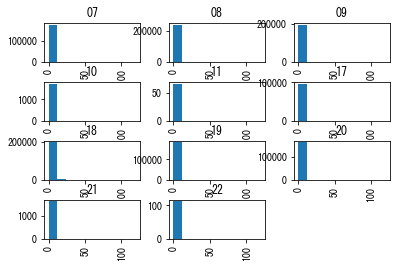

学習用データ


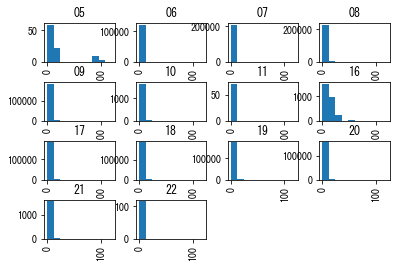

In [29]:
print("予測データ")
eng_test.hist(column="delayTime",by="PlanTimeHour",range=(0,120))
plt.show()
print("学習用データ")
train_df.hist(column="delayTime",by="PlanTimeHour",range=(0,120))
plt.show()

In [100]:
info_df = pd.read_csv(info_path)
info_date = info_df["date"].unique()

In [101]:
info_df["PlanTimeHour"] = info_df["time"].apply(lambda x:x.split(":")[0])
eng_test["PlanTimeHour"] = eng_test["PlanTimeHour"].apply(lambda x:x if x[0] != "0" else x[1])
train_df["PlanTimeHour"] = train_df["PlanTimeHour"].apply(lambda x:x if x[0] != "0" else x[1])

In [119]:
eng_test["infoTag"] = 0
for date in tqdm(info_date):
    lineNames = info_df[info_df["date"]==date]["lineName"].unique()
    Hours = info_df[info_df["date"]==date]["PlanTimeHour"].unique()
    all_tag = info_df[info_df["date"]==date]["all"].unique()
    for line in lineNames:
        for hour in Hours:
            if all_tag[0] == 0:
                eng_test.loc[(eng_test["date"]==date)&
                         (eng_test["lineName"]==line)&
                         (eng_test["PlanTimeHour"]==hour),"infoTag"]=2
            else:
                eng_test.loc[(eng_test["date"]==date)&
                         (eng_test["lineName"]==line)&
                         (eng_test["PlanTimeHour"]==hour),"infoTag"]=1

100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:23<00:00,  2.39it/s]


In [116]:
eng_test.to_csv("../enginier_data/test.csv")

In [120]:
info_df[info_df["all"]!=1]

,info_id,date,time,lineName,directionCode1,directionCode2,all,station_from,station_to,cse,PlanTimeHour
96,96,20200217,8:06,A,1,1,0,CTnl,vpGT,線路に支障物,8
97,97,20200217,8:10,A,1,1,0,CTnl,vpGT,線路に支障物,8
98,98,20200217,8:12,A,1,1,0,CTnl,vpGT,線路に支障物,8
99,99,20200217,8:16,A,1,1,0,CTnl,vpGT,線路に支障物,8
100,100,20200217,8:16,A,1,1,0,daXW,CTnl,線路に支障物,8
...,...,...,...,...,...,...,...,...,...,...,...
876,876,20200528,18:15,D,1,1,0,yuIQ,RDLf,人身事故,18
877,877,20200528,18:41,D,1,1,0,yuIQ,RDLf,人身事故,18
993,993,20200820,17:39,D,1,1,0,wwYD,fZfY,人身事故,17
996,996,20200820,17:44,D,1,1,0,wwYD,fZfY,人身事故,17


In [124]:
eng_test[(eng_test["infoTag"]==1)&(eng_test["target"]==1)]

,Unnamed: 0,id,date,lineName,directionCode,trainNo,stopStation,planArrival,delayTime,target,HTime,PlanTimeHour,infoTag
394365,394365,1883250,20200115,A,1,MQaQiS,PcxI,19:03,4.0,1,19,19,1
394366,394366,1883251,20200115,A,1,MQaQiS,ejfb,19:05,4.0,1,19,19,1
394367,394367,1883252,20200115,A,1,MQaQiS,RDLf,19:07,4.0,1,19,19,1
394368,394368,1883253,20200115,A,1,MQaQiS,cRgf,19:10,4.0,1,19,19,1
394369,394369,1883254,20200115,A,1,MQaQiS,SvNu,19:12,4.0,1,19,19,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
495506,495506,1984391,20200127,D,2,xziPhn,BCRD,19:42,0.0,1,19,19,1
495507,495507,1984392,20200127,D,2,xziPhn,AVjc,19:46,0.0,1,19,19,1
495508,495508,1984393,20200127,D,2,xziPhn,uYlv,19:49,0.0,1,19,19,1
495509,495509,1984394,20200127,D,2,xziPhn,wwYD,19:54,0.0,1,19,19,1


In [127]:
info_dict = {}
for date in tqdm(info_date):
    hour_dict = {}
    line_dict = {}
    lineNames = info_df[info_df["date"]==date]["lineName"].unique()
    Hours = info_df[info_df["date"]==date]["PlanTimeHour"].unique()
    for line in lineNames:
        for hour in Hours:
            try:
                hour_dict["{}".format(hour)] = train_df[(train_df["date"]==date)&
                                                        (train_df["PlanTimeHour"]==hour)&
                                                        (train_df["lineName"]==line)]["delayTime"].mean()
            except:
                hour_dict["{}".format(hour)] = 999
        line_dict["{}".format(line)] = hour_dict
    info_dict["{}".format(date)] = line_dict

100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:25<00:00,  2.23it/s]


In [132]:
pprint(info_dict)

{'20191206': {'D': {'20': 1.4714548802946592}},
 '20191211': {'A': {'20': 0.7126099706744868, '7': nan}},
 '20191213': {'C': {'17': nan}},
 '20191215': {'A': {'7': nan}},
 '20191216': {'C': {'17': nan}},
 '20191220': {'A': {'8': 10.378348214285714, '9': 14.700189753320682},
              'D': {'8': 10.378348214285714, '9': 14.700189753320682}},
 '20191223': {'C': {'7': nan}},
 '20191227': {'A': {'16': nan, '17': nan, '18': nan}},
 '20191231': {'A': {'16': 19.61986301369863,
                    '17': 16.965082444228905,
                    '18': 13.85085085085085,
                    '19': 9.72554347826087,
                    '20': 1.6957186544342508},
              'C': {'16': 19.61986301369863,
                    '17': 16.965082444228905,
                    '18': 13.85085085085085,
                    '19': 9.72554347826087,
                    '20': 1.6957186544342508},
              'D': {'16': 19.61986301369863,
                    '17': 16.965082444228905,
                    '

In [135]:
eng_test[eng_test["infoTag"]==1]

,Unnamed: 0,id,date,lineName,directionCode,trainNo,stopStation,planArrival,delayTime,target,HTime,PlanTimeHour,infoTag
116729,116729,1605614,20191211,A,1,AFGKvJ,tPfo,07:00,0.0,0,7,7,1
116730,116730,1605615,20191211,A,1,AFGKvJ,jPbe,07:03,0.0,0,7,7,1
116731,116731,1605616,20191211,A,1,AFGKvJ,stJE,07:06,0.0,0,7,7,1
116732,116732,1605617,20191211,A,1,AFGKvJ,ufGe,07:08,0.0,0,7,7,1
116733,116733,1605618,20191211,A,1,AFGKvJ,tncu,07:10,14.0,0,7,7,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1138646,1138646,2627531,20200923,D,2,uwKmQu,LMww,08:48,0.0,0,8,8,1
1138647,1138647,2627532,20200923,D,2,uwKmQu,coZB,08:50,0.0,0,8,8,1
1138648,1138648,2627533,20200923,D,2,uwKmQu,Rlfq,08:53,0.0,0,8,8,1
1138649,1138649,2627534,20200923,D,2,uwKmQu,daXW,08:55,0.0,0,8,8,1


In [152]:
for date in tqdm(info_date):
    lineNames = info_df[info_df["date"]==date]["lineName"].unique()
    Hours = info_df[info_df["date"]==date]["PlanTimeHour"].unique()
    d1 = info_dict["{}".format(date)]
    for line in lineNames:
        d2 = d1["{}".format(line)]
        for hour in Hours:
            h = d2["{}".format(hour)]
            if np.isnan(h):
                eng_test.loc[(eng_test["date"]==date)&
                             (eng_test["PlanTimeHour"]==hour)&
                             (eng_test["lineName"]==line),"delayTime"] = 15
            else:
                eng_test.loc[(eng_test["date"]==date)&
                             (eng_test["PlanTimeHour"]==hour)&
                             (eng_test["lineName"]==line),"delayTime"] = h

100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:23<00:00,  2.42it/s]


In [163]:
eng_test.to_csv("../enginier_data/info_tag15_test.csv")

In [158]:
eng_test[eng_test["infoTag"]==1]

,Unnamed: 0,id,date,lineName,directionCode,trainNo,stopStation,planArrival,delayTime,target,HTime,PlanTimeHour,infoTag
116729,116729,1605614,20191211,A,1,AFGKvJ,tPfo,07:00,15.0,0,7,7,1
116730,116730,1605615,20191211,A,1,AFGKvJ,jPbe,07:03,15.0,0,7,7,1
116731,116731,1605616,20191211,A,1,AFGKvJ,stJE,07:06,15.0,0,7,7,1
116732,116732,1605617,20191211,A,1,AFGKvJ,ufGe,07:08,15.0,0,7,7,1
116733,116733,1605618,20191211,A,1,AFGKvJ,tncu,07:10,15.0,0,7,7,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1138646,1138646,2627531,20200923,D,2,uwKmQu,LMww,08:48,15.0,0,8,8,1
1138647,1138647,2627532,20200923,D,2,uwKmQu,coZB,08:50,15.0,0,8,8,1
1138648,1138648,2627533,20200923,D,2,uwKmQu,Rlfq,08:53,15.0,0,8,8,1
1138649,1138649,2627534,20200923,D,2,uwKmQu,daXW,08:55,15.0,0,8,8,1


In [161]:
info_df

,info_id,date,time,lineName,directionCode1,directionCode2,all,station_from,station_to,cse,PlanTimeHour
0,0,20191220,8:04,A,1,1,1,-,-,車両点検,8
1,1,20191220,8:09,A,1,1,1,-,-,車両点検,8
2,2,20191220,8:14,A,1,1,1,-,-,車両点検,8
3,3,20191220,8:16,A,1,1,1,-,-,車両点検,8
4,4,20191220,8:25,A,1,1,1,-,-,車両点検,8
...,...,...,...,...,...,...,...,...,...,...,...
1036,1036,20200324,18:41,D,1,1,1,-,-,人身事故,18
1037,1037,20200324,18:43,D,1,1,1,-,-,人身事故,18
1038,1038,20200324,18:54,D,1,0,1,-,-,人身事故,18
1039,1039,20200321,18:40,C,1,1,1,-,-,異音の確認,18
